# **Лабораторная работа №4. Кодировки категориальных признаков.**

# 1. Выбрать и загрузить датасет для задачи регрессии (можно взять из UCI), содержащий как вещественные, так и категориальные признаки. Очень желательно, чтобы количество наблюдений в датасете было больше 1к. В данной работе в качестве метрик качества можно использовать R^2, MAE, RMSE. Временно убрать категориальные признаки и обучить модель линейной регрессии только на оставшихся вещественных признаках.

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, TargetEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error
from category_encoders import TargetEncoder as CETargetEncoder
from catboost import CatBoostRegressor, Pool

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [11]:
X = train.drop(['SalePrice', 'Id'], axis=1)
y = train['SalePrice']

In [18]:
# грубо разделим признаки на числовые и категориальные
X_real = X.select_dtypes(include=['int64', 'float64'])
X_cat = X.select_dtypes(include=['object'])

In [43]:
# грубо удалим признаки с пропусками в числовых и категориальных данных
X_real.dropna(axis=1, inplace=True)
X_cat.dropna(axis=1, inplace=True)
X.dropna(axis=1, inplace=True)

In [29]:
X_real_train, X_real_val, y_train, y_val = train_test_split(X_real, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_real_train_scaled = scaler.fit_transform(X_real_train)
X_real_val_scaled = scaler.transform(X_real_val)

<Axes: >

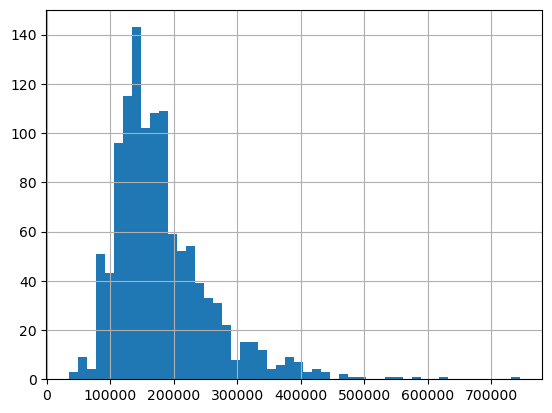

In [35]:
# Распределение целевой переменной
y_train.hist(bins=50)

<Axes: >

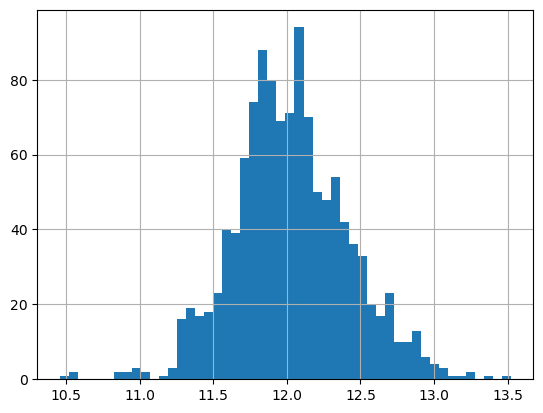

In [39]:
# можно также попробовать логарифмирование целевой переменной
np.log1p(y_train).hist(bins=50)

In [30]:
linear_model = LinearRegression()
linear_model.fit(X_real_train_scaled, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [32]:
# Оценка модели со скейлером
y_pred = linear_model.predict(X_real_val_scaled)
rmse = root_mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
print(f"RMSE: {rmse}, R2: {r2}, MAE: {mae}")

RMSE: 37312.271522962044, R2: 0.8184946026286676, MAE: 22938.25150819949


In [33]:
# Оценка модели без скейлера
linear_model_no_scaler = LinearRegression()
linear_model_no_scaler.fit(X_real_train, y_train)
y_pred_no_scaler = linear_model_no_scaler.predict(X_real_val)
rmse_no_scaler = root_mean_squared_error(y_val, y_pred_no_scaler)
r2_no_scaler = r2_score(y_val, y_pred_no_scaler)
mae_no_scaler = mean_absolute_error(y_val, y_pred_no_scaler)
print(f"Without Scaler - RMSE: {rmse_no_scaler}, R2: {r2_no_scaler}, MAE: {mae_no_scaler}")

Without Scaler - RMSE: 37312.27152296134, R2: 0.8184946026286745, MAE: 22938.251508198


**Вывод:** грубо убрав точно категориальные переменные и переменные с пропущенными значениями (далеко не все из них стоит удалять), получили начальный результат. Применение скейлера не даёт никакого улучшения или ухудшения метрик.

# 2. На этих же вещественных признаках обучить модель градиентного бустинга

In [37]:
gb_model = GradientBoostingRegressor()
gb_model.fit(X_real_train, y_train)
y_pred_gb = gb_model.predict(X_real_val)
rmse_gb = root_mean_squared_error(y_val, y_pred_gb)
r2_gb = r2_score(y_val, y_pred_gb)
mae_gb = mean_absolute_error(y_val, y_pred_gb)
print(f"Gradient Boosting - RMSE: {rmse_gb}, R2: {r2_gb}, MAE: {mae_gb}")

Gradient Boosting - RMSE: 28670.373537656233, R2: 0.8928350246670694, MAE: 17416.171500093496


**Вывод:** Градиентный бустинг с параметрами по умолчанию на тех же переменных показал результат значительно лучше.

# 3. Для категориальных признаков применить one-hot, label и target encoding. Для каждой из кодировок обучить линейную регрессию и тот же бустинг

In [53]:
cat_features = X_cat.columns.tolist()
print(cat_features)

['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', 'KitchenQual', 'Functional', 'PavedDrive', 'SaleType', 'SaleCondition']


In [55]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# One-Hot Encoding
ohe = OneHotEncoder(handle_unknown='ignore')
X_train_ohe = ohe.fit_transform(X_train)
X_val_ohe = ohe.transform(X_val)
linear_model_ohe = LinearRegression()
linear_model_ohe.fit(X_train_ohe, y_train)
y_pred_ohe = linear_model_ohe.predict(X_val_ohe)
rmse_ohe = root_mean_squared_error(y_val, y_pred_ohe)
r2_ohe = r2_score(y_val, y_pred_ohe)
mae_ohe = mean_absolute_error(y_val, y_pred_ohe)
print(f"One-Hot Encoding linear regression - RMSE: {rmse_ohe}, R2: {r2_ohe}, MAE: {mae_ohe}")

gb_model_ohe = GradientBoostingRegressor()
gb_model_ohe.fit(X_train_ohe, y_train)
y_pred_gb_ohe = gb_model_ohe.predict(X_val_ohe)
rmse_gb_ohe = root_mean_squared_error(y_val, y_pred_gb_ohe)
r2_gb_ohe = r2_score(y_val, y_pred_gb_ohe)
mae_gb_ohe = mean_absolute_error(y_val, y_pred_gb_ohe)
print(f"One-Hot Encoding Gradient Boosting - RMSE: {rmse_gb_ohe}, R2: {r2_gb_ohe}, MAE: {mae_gb_ohe}")

One-Hot Encoding linear regression - RMSE: 37062.89278021558, R2: 0.820912698608485, MAE: 23053.600526826456
One-Hot Encoding Gradient Boosting - RMSE: 35028.657741921495, R2: 0.8400319842914938, MAE: 22417.49902631304


In [59]:
# label encoding даёт ошибку при наличии новых категорий в валидационном наборе
# поэтому используем OrdinalEncoder с обработкой неизвестных категорий

oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

X_train_le = X_train.copy()
X_val_le = X_val.copy()

# применяем только к категориальным признакам
X_train_le[cat_features] = oe.fit_transform(X_train_le[cat_features])
X_val_le[cat_features] = oe.transform(X_val_le[cat_features])

linear_model_le = LinearRegression()
linear_model_le.fit(X_train_le, y_train)
y_pred_le = linear_model_le.predict(X_val_le)
rmse_le = root_mean_squared_error(y_val, y_pred_le)
r2_le = r2_score(y_val, y_pred_le)
mae_le = mean_absolute_error(y_val, y_pred_le)
print(f"Label Encoding linear regression - RMSE: {rmse_le}, R2: {r2_le}, MAE: {mae_le}")

gb_model_le = GradientBoostingRegressor()
gb_model_le.fit(X_train_le, y_train)
y_pred_gb_le = gb_model_le.predict(X_val_le)
rmse_gb_le = root_mean_squared_error(y_val, y_pred_gb_le)
r2_gb_le = r2_score(y_val, y_pred_gb_le)
mae_gb_le = mean_absolute_error(y_val, y_pred_gb_le)
print(f"Label Encoding Gradient Boosting - RMSE: {rmse_gb_le}, R2: {r2_gb_le}, MAE: {mae_gb_le}")

Label Encoding linear regression - RMSE: 34680.721368785285, R2: 0.8431940960304483, MAE: 21513.31944119619
Label Encoding Gradient Boosting - RMSE: 29561.004042101355, R2: 0.8860735597974531, MAE: 17624.488760285814


In [68]:
# Target Encoding
te = CETargetEncoder(cols=cat_features, smoothing=0.3)

X_train_te = X_train.copy()
X_val_te = X_val.copy()

# обучаем энкодер на трейне и трансформируем
X_train_te[cat_features] = te.fit_transform(X_train_te[cat_features], y_train)
X_val_te[cat_features] = te.transform(X_val_te[cat_features])

# на случай пропусков после преобразования — заполнить глобальным средним целевой
global_mean = y_train.mean()
X_train_te.fillna(global_mean, inplace=True)
X_val_te.fillna(global_mean, inplace=True)

# линейная регрессия
linear_model_te = LinearRegression()
linear_model_te.fit(X_train_te, y_train)
y_pred_te = linear_model_te.predict(X_val_te)
rmse_te = root_mean_squared_error(y_val, y_pred_te)
r2_te = r2_score(y_val, y_pred_te)
mae_te = mean_absolute_error(y_val, y_pred_te)
print(f"Target Encoding linear regression - RMSE: {rmse_te}, R2: {r2_te}, MAE: {mae_te}")

# градиентный бустинг
gb_model_te = GradientBoostingRegressor()
gb_model_te.fit(X_train_te, y_train)
y_pred_gb_te = gb_model_te.predict(X_val_te)
rmse_gb_te = root_mean_squared_error(y_val, y_pred_gb_te)
r2_gb_te = r2_score(y_val, y_pred_gb_te)
mae_gb_te = mean_absolute_error(y_val, y_pred_gb_te)
print(f"Target Encoding Gradient Boosting - RMSE: {rmse_gb_te}, R2: {r2_gb_te}, MAE: {mae_gb_te}")

Target Encoding linear regression - RMSE: 33819.701159231554, R2: 0.8508835014828954, MAE: 20583.541031981575
Target Encoding Gradient Boosting - RMSE: 26319.578442846167, R2: 0.9096882986853869, MAE: 16288.465720790413


**Вывод:** One-hot encoder показал себя хуже всего, затем label encoder и target encoder позволил получить лучшее качество, как у линейной модели, так и у градиентного бустинга.

# 4. Не применяя кодировки, обучить catboost на исходных данных

In [73]:
train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
val_pool = Pool(data=X_val, label=y_val, cat_features=cat_features)

catboost_model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, eval_metric='RMSE', random_seed=42, verbose=100)
catboost_model.fit(train_pool, eval_set=val_pool, use_best_model=True, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 72483.8436693	test: 82833.4568165	best: 82833.4568165 (0)	total: 37.9ms	remaining: 37.8s
100:	learn: 16387.1440407	test: 26910.5103415	best: 26904.1339295 (99)	total: 2.35s	remaining: 20.9s
200:	learn: 12582.0567044	test: 26181.9798826	best: 26131.7062022 (192)	total: 4.79s	remaining: 19s
300:	learn: 10149.4297981	test: 26104.6545600	best: 26093.9818022 (290)	total: 7.06s	remaining: 16.4s
400:	learn: 8543.4111525	test: 26104.9784512	best: 26079.7547679 (390)	total: 9.59s	remaining: 14.3s
500:	learn: 7143.1481507	test: 26158.6901108	best: 26022.8312704 (436)	total: 12s	remaining: 11.9s
600:	learn: 6148.2035672	test: 26130.2649544	best: 26022.8312704 (436)	total: 14.3s	remaining: 9.48s
700:	learn: 5363.9195405	test: 26162.4503409	best: 26022.8312704 (436)	total: 16.6s	remaining: 7.06s
800:	learn: 4764.8807751	test: 26163.9995785	best: 26022.8312704 (436)	total: 19s	remaining: 4.71s
900:	learn: 4202.6312490	test: 26183.7898925	best: 26022.8312704 (436)	total: 21.2s	remaining: 2.

In [74]:
y_pred_cb = catboost_model.predict(val_pool)
rmse_cb = root_mean_squared_error(y_val, y_pred_cb)
r2_cb = r2_score(y_val, y_pred_cb)
mae_cb = mean_absolute_error(y_val, y_pred_cb)
print(f"CatBoost - RMSE: {rmse_cb}, R2: {r2_cb}, MAE: {mae_cb}")

CatBoost - RMSE: 26022.831270420083, R2: 0.9117133054009847, MAE: 15953.265702940753


**Вывод:**